In [63]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [64]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Using device: cuda


In [65]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_5s_0.05s.pt')
target_tensors = torch.load('target_tensors_5s_0.05s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

FileNotFoundError: [Errno 2] No such file or directory: 'data_tensors_5s_0.05ss.pt'

In [66]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [32]:
# Normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# Make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_std

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
input_size = len(train_dataset[0][0][0])  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size).to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [34]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
# model.load_state_dict(torch.load('model_weights_5s_0.05s.pt'))

num_epochs = 5000

model.train()
with tqdm(total=num_epochs) as pbar:
    prev_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)

        prev_loss = average_loss


Epoch 5000, Loss: 0.0759: 100%|██████████| 5000/5000 [19:49<00:00,  4.20it/s] 


In [49]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_5s_0.05s.pt')

In [50]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total absolute error
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.30195683652961935


In [51]:
# Initialize variables to calculate total absolute error for denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value and denormalize it
        predicted_value = denormalize(model(input_tensor).item())
        actual_value = denormalize(target_value.item())

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 34.09743118286133


In [52]:
# Initialize list to store absolute errors
absolute_errors = []

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error and append to list
        absolute_error = abs(predicted_value - actual_value)
        absolute_errors.append(absolute_error)

# Calculate median absolute error
median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.027223780751228333


In [53]:
# get the median absolute error for the denormalized values
absolute_errors = []

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 3.074152946472168


In [54]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0).to(device)).item()
    actual_value = test_targets[i].to(device).item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 1.465734317889193


In [55]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 18690.005859375


In [56]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].to(device).unsqueeze(0)).item()
    actual_value = test_targets[i].to(device).item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.11767368763685226, Predicted: -0.07801973819732666
Actual: -0.2535720765590668, Predicted: -0.24193286895751953
Actual: -0.25784480571746826, Predicted: -0.2611175775527954
Actual: -0.22154006361961365, Predicted: -0.12073147296905518
Actual: -0.21547110378742218, Predicted: -0.25290632247924805
Actual: -0.2157062590122223, Predicted: -0.1217796802520752
Actual: 0.15565110743045807, Predicted: 2.7745282649993896
Actual: -0.2596759796142578, Predicted: 0.8511537313461304
Actual: -0.24989363551139832, Predicted: -0.25363457202911377
Actual: -0.25129133462905884, Predicted: -0.24965286254882812
Actual: -0.25246086716651917, Predicted: -0.25990796089172363
Actual: -0.23853756487369537, Predicted: -0.22032713890075684
Actual: -0.2574392855167389, Predicted: -0.2063387632369995
Actual: -0.20480549335479736, Predicted: -0.2027444839477539
Actual: -0.2389136701822281, Predicted: -0.2464594841003418
Actual: 0.47060853242874146, Predicted: 0.09634339809417725
Actual: -0.14688748121261

In [57]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: 16.160232543945312, Predicted: 20.638019561767578
Actual: 0.8143672943115234, Predicted: 2.1286849975585938
Actual: 0.3318824768066406, Predicted: -0.03768348693847656
Actual: 4.4314727783203125, Predicted: 15.814942359924316
Actual: 5.116790771484375, Predicted: 0.8895454406738281
Actual: 5.090236663818359, Predicted: 15.696577072143555
Actual: 47.02450942993164, Predicted: 342.7523193359375
Actual: 0.1251049041748047, Predicted: 125.5617904663086
Actual: 1.2297420501708984, Predicted: 0.8073101043701172
Actual: 1.0719127655029297, Predicted: 1.2569313049316406
Actual: 0.9398460388183594, Predicted: 0.09890937805175781
Actual: 2.5120887756347656, Predicted: 4.568439483642578
Actual: 0.37767601013183594, Predicted: 6.148029327392578
Actual: 6.321168899536133, Predicted: 6.553899765014648
Actual: 2.4696178436279297, Predicted: 1.617532730102539
Actual: 82.59001159667969, Predicted: 40.327388763427734
Actual: 12.861364364624023, Predicted: 6.241315841674805
Actual: 6.305616378784

In [58]:
# Calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")

# Print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 200.04307494151809%
Standard Deviation of Percentage Errors: 10.527563714112528
Average Percentage Error (Without Top 2%): 69.729248046875%
Standard Deviation of Percentage Errors (Without Top 2%): 9.963765376362721


In [59]:
# Calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# Print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors for denormalized values (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")


Average Percentage Error (Denormalized): 636.2183227539062%
Standard Deviation of Percentage Errors (Denormalized): 43.539249420166016
Average Percentage Error (Without Top 2%, Denormalized): 69.729248046875%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 43.975677490234375


In [60]:
# Calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 12.800711630765907%


In [61]:
# Calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")


Median Percentage Error (Denormalized): 82.50763416290283%


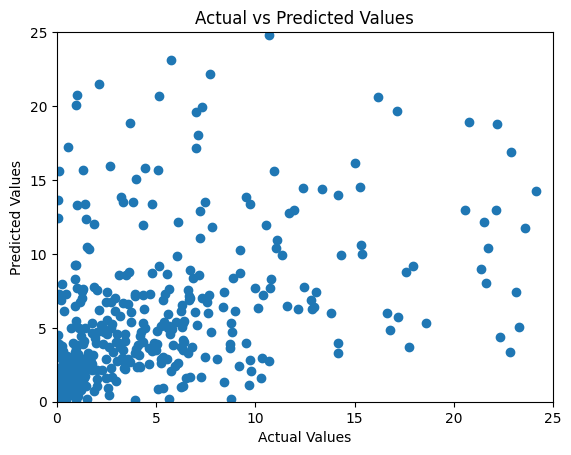

In [62]:
# Plot the denormalized values for the actual and predicted values on the testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()
